# Bautista Daniela Lorriz - Matricola 900074<br>Progetto per il corso di Introduzione all'Intelligenza Artificiale 2024/25
## Obiettivo dell'analisi
Dato il dataset si vuole fare clustering per esplorare il dataset e cercare di segmentare le transazioni.<br>
Il dataset in analisi contiene ordini da un sito di E-commerce, con vari prodotti e ordini.<br>
Il clustering ci permette di esplorare il dataset in modo non supervisionato, senza quindi dover definire a priori un obettivo specifico, e di segmenentare/raggruppare le transazioni per trovare pattern di acquisto.

## Esplorazione dei dati (EDA)
### Caricamento del dataset
Carichiamo il dataset e verifichiamo le prime righe.<br>
Il file csv contiene caratteri che non sono validi in UTF-8: byte 0xa3 che corrisponde al simbolo di sterlina (£) nella codifica in latin1 (ISO-8859-1).<br>
Specifichiamo quindi la codifica.

In [3]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

df = pd.read_csv('data.csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Esplorazione iniziale

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Le colonne includono:
1. **InvoiceNo:** Identificatore univoco per ciascuna transazione
2. **StockCode:** Codice che rappresenta il prodotto
3. **Description:** Testo che descrive il prodotto
4. **Quantity:** Numero di prodotti venduti per ciascuna transazione
5. **InvoiceDate:** Giorno e data di ciascuna transazione
6. **UnitPrice:** Prezzo di ciascun prodotto nelle transazione
7. **CustomerID:** Identificatore per il cliente
8. **Country:** Paese in cui è avvenuta la transazione

In [7]:
df.shape

(541909, 8)

### Statistiche descrittive
Vediamo quali sono le statistiche descrittive del dataset per capire la distribuzione dei dati.

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Pulizia dei dati
### Dati mancanti
Identifichiamo ora le colonne con dati mancanti

In [11]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Le colonne `Description` e `CustomerID` risultano quindi essere colonne con dati mancanti.<br>
Per poter fare uno studio completo sostituisco nel dataset originale le colonne con dati mancanti inserendo nella colonna `Description` il valore `Unknown` e nella colonna `CustomerID` il valore `0`.

In [13]:
df['Description'] = df['Description'].fillna("Unknown")
df['CustomerID'] = df['CustomerID'].fillna(0)

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Dati duplicati
Controlliamo se ci sono dati duplicati. In caso affermativo, rimuoverli dal dataset.

In [15]:
df.duplicated().sum()

5268

In [16]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [17]:
df.shape

(536641, 8)

## Data analysis
Ora che i dati sono puliti, passiamo all'analisi esplorativa dei dati per comprendere meglio il dataset e per prendere decisioni sulla scelta delle variabili e dei modelli da utilizzare per il clustering.

### Visualizzazione delle distribuzioni di variabili con valori numerici
#### Quantity

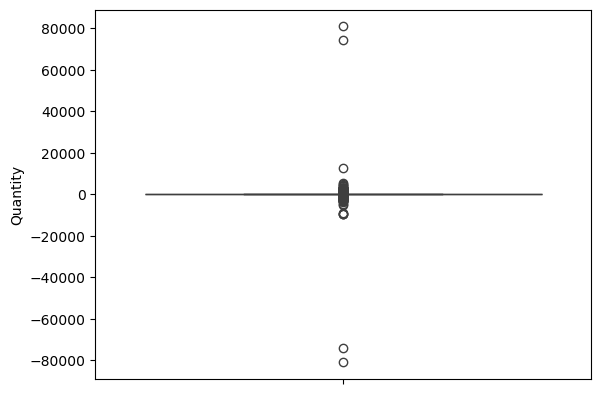

In [20]:
sns.boxplot(df['Quantity'])
plt.show()

In [21]:
print((df['Quantity'] < 0).sum())
print((df['Description'] == "Discount").sum())
df[df['Quantity'] < 0].head()

10587
77


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


Dal box plot di `Quantity` notiamo una certa simmetria tra le quantità postivie e negative delle transizioni. Inoltre, questi rappresentano una parte significativa del dataset ~2.0% delle transazioni. Considero quindi di mantere le transazioni con quantità negative (probabilmente resi) per l'analisi.<br> Infatti i resi potrebbero darmi informazioni in più quando procederemo a fare il clustering, come ad esempio segmentare i clienti in base al loro comportamento di acquisto o i prodotti problematici.

Notiamo inoltre che tra le quantità negative vi sono righe con `Description` `Discount`. Per ragioni di semplicità ed essendo il loro numero molto piccolo rispetto al dataset, decido invece di eliminare le righe con `Discount`.

In [24]:
df = df[~df['Description'].str.contains('Discount', case=False, na=False)]
print((df['Description'] == "Discount").sum())

0


Per utilizzare i resi per il clustering ma distinguerli dalle vendite normali, aggiungo una colonna `isReturn` come `feature aggiuntiva` per indicare se una transazione è un reso o meno.

In [26]:
df['IsReturn']=df['Quantity'].apply(lambda x: 1 if x < 0 else 0)

#### UnitPrice

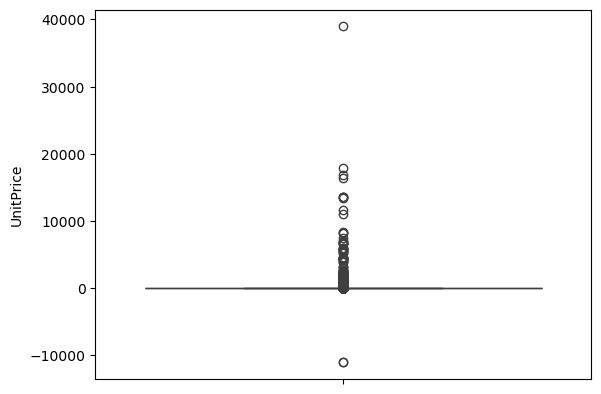

In [28]:
sns.boxplot(df['UnitPrice'])
plt.show()

In [29]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsReturn
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,0.0,United Kingdom,0
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,0.0,United Kingdom,0


Dalla boxplot invece ricaviamo che vi sono diversi `outliers` nei valori di `UnitPrice`, con uno negativo. Infatti dal metodo `df.describe()` notiamo che il valore minimo della `UnitPrice` è -11062.<br>
Poiché dalla tabella leggiamo che queste transazioni sono *cattivi debiti* e non prodotti venduti, possiamo procedere con la rimozioni di questi valori dal dataset.

In [31]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice,CustomerID,IsReturn
count,534052.000000,534052.000000,534052.000000,534052.000000
mean,9.920483,4.686090,11488.127100,0.017178
std,216.465039,95.046572,6766.509005,0.129935
min,-80995.000000,0.001000,0.000000,0.000000
25%,1.000000,1.250000,12360.000000,0.000000
50%,3.000000,2.100000,14367.000000,0.000000
75%,10.000000,4.130000,16249.000000,0.000000
max,80995.000000,38970.000000,18287.000000,1.000000


### Analisi delle correlazioni
Ora vado a vedere se sussistono relazioni tra i dati numerici disponibili sui prodotti, ovvero `Quantity` e `UnitPrice`.

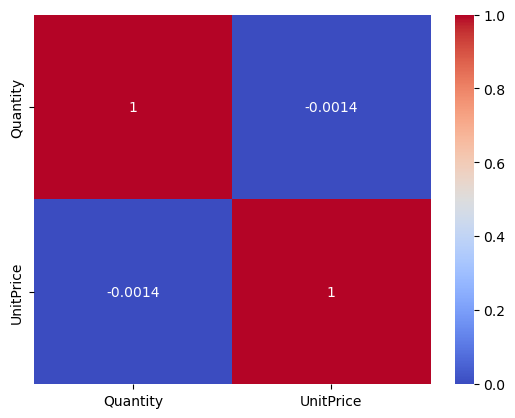

In [33]:
correlation_matrix = df[['Quantity', 'UnitPrice']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

La correlazione tra `Quantity` e `UnitPrice` è -0.0014, che è molto vicina a 0, ovvero `non` c'è una `relazione lineare` significativa tra queste due variabili.<br>
Ciò significa che la quantità acquistata non sia correlata al prezzo unitario. Ad esempio, i clienti potrebbero acquistare grandi quantità di prodotti di basso prezzo o piccole quantità di prodotti costosi, senza quindi un pattern chiaro.

## Primo clustering dei Clienti 
Possiamo quindi procedere con clustering iniziale di queste feature per identificare i vari gruppi di comportamento d'acquisto dei clienti. 

### Preparazione dei dati
Selezioniamo le feature rilevanti (`Quantity`, `UnitPrice`, `isReturn`) e normalizziamole.

In [37]:
features = ['Quantity', 'UnitPrice', 'IsReturn']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Applicazione del Clustering
Utilizziamo il **Metodo del Gomito** per determinare il numero ottimale di cluster ed utilizziamo poi l'algoritmo di clustering **K-Means** per determinare quali siano i cluster.

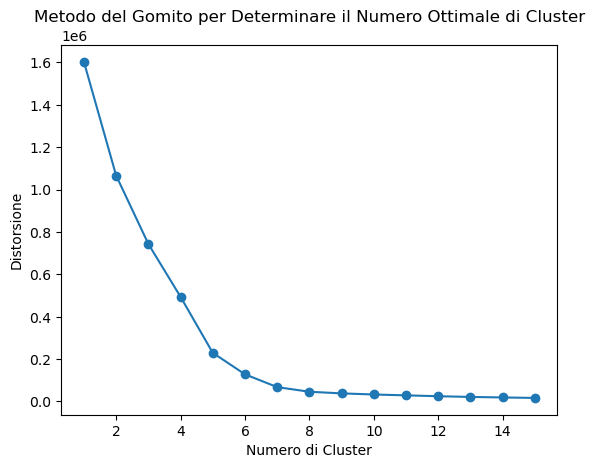


Il numero ottimale di cluster è: 4


In [39]:
dist = []

for i in range(1, 16):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    km.fit(X_scaled)
    dist.append(km.inertia_)

plt.plot(range(1, 16), dist, marker = 'o')
plt.xlabel('Numero di Cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del Gomito per Determinare il Numero Ottimale di Cluster')
plt.show()

optimal_k = 0
min_slope = float('inf')

for i in range(1, len(dist) - 1):
    slope = dist[i-1] - dist[i]
    next_slope = dist[i] - dist[i+1]
    if (slope - next_slope) < min_slope:
        min_slope = (slope - next_slope)
        optimal_k = i + 1

print(f"\nIl numero ottimale di cluster è: {optimal_k}")

In [40]:
kmeans = KMeans(n_clusters = optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

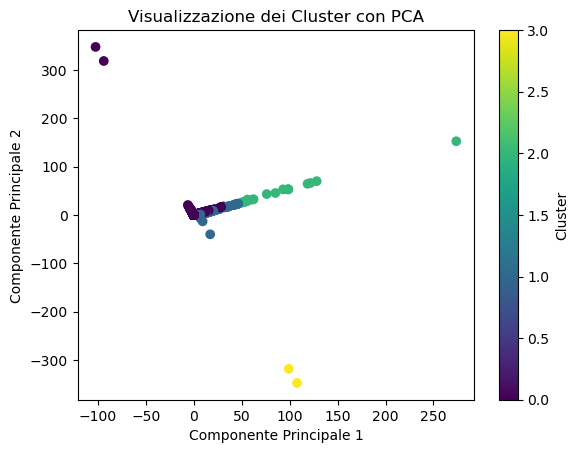

In [41]:
# Riduciamo la dimensione con PCA per visualizzare i cluster
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.scatter(principal_components[:, 0], principal_components[:,1], c=df['Cluster'], cmap='viridis')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Visualizzazione dei Cluster con PCA')
plt.colorbar(label='Cluster')
plt.show()

In [42]:
cluster_summary = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'IsReturn': 'mean'
}).rename(columns={
    'Quantity': 'Quantità Media',
    'UnitPrice': 'Prezzo Medio Unitario',
    'IsReturn': 'Percentuale di Resi'
})

print(cluster_summary)

         Quantità Media  Prezzo Medio Unitario  Percentuale di Resi
Cluster                                                            
0             10.616655               3.860207                 0.00
1            -13.013545              25.894773                 1.00
2             -0.700000           11971.005500                 0.85
3         -77605.000000               1.560000                 1.00


### Risultati ottenuti
`Cluster 0`
+ **Quantità media:** 10.62
+ **Prezzo Medio Unitario:** 3.86
+ **Percentuale di Resi:** 0.00 (nessun reso)
Questo cluster sembra rappresentare transazioni regolari con una quantità media moderata e un prezzo unitario relativamente basso. Inoltre, non ci sono resi suggerendo che queste transazioni sono probabilmente normali acquisti.<br>

`Cluster 1`
+ **Quantità media:** -13.01
+ **Prezzo Medio Unitario:** 25.89
+ **Percentuale di Resi:** 1.00 (tutti resi)
Questo cluster invece rappresenta le transazioni di resi, con una quantità media negativa (indicando appunto un reso) e un prezzo unitario medio più alto. Ogni transazioni in questo cluster è un reso.<br>

`Cluster 2`
+ **Quantità media:** -0.70
+ **Prezzo Medio Unitario:** 11971.01
+ **Percentuale di Resi:** 0.85
Questo cluster ha quantità media leggermente negativa, indicando che la maggior parte delle transazioni sono resi. Infatti, la percentuale dei resi è del `0.85`. Inoltre, il prezzo unitario medio è il più alto tra i cluster, che potrebbe indicare resi di articoli di alto valore. <br>
Questo cluster potrebbe raggruppare i clienti che acquistano prodotti costosi e poi li restituiscono. <br>

`Cluster 3`
+ **Quantità media:** -77605.00
+ **Prezzo Medio Unitario:** 1.56
+ **Percentuale di Resi:** 1.00 (tutti resi)
Questo cluster mostra una quantità media estremamente negativa, indicando resi di tanti prodotti, ma con prezzo unitario molto basso. Questo cluster potrebbe rappresentare una situazione anomala o un problema con un certo prodotto causando un grande numero di resi.

### Deduzioni Generali e Ulteriori Azioni
+ I cluster 1,2 e 3 sono associati ai resi, con il cluster 3 che rapprsenta un caso estremo. <br> Potremmo usare la colonna `Description` per identificare le categorie di prodotti più soggette a resi con il `TF-IDF`. Inoltre, potremmo procedere con l'analisi costruendo un `Modello di Classificazione` per prevedere se una transazione ha un'alta probabilità di diventare un reso.
+ Il cluster 0 rappresenta transazioni regolari senza resi, con un prezzo unitario medio più basso. Questi potrebbero essere i clienti più soddisfatti o i prodotti più affidabili. Potremmo ulteriormente segmentare questi clienti con `clustering` basato sulla **recentità** e **frequenza** d'acquisto, e **importo totale** speso.

## Analisi NLP sui prodotti
Ora possiamo quindi usare la colonna `Description`, che contiene informazioni testuali sul prodotto, per identificare pattern nei prodotti restituiti. <br>Utilizzeremo il metodo `TF-IDF` (Term Frequency - Inverse Document Frequency) per trasformare il testo in numeri che misureranno quanto una parola è importante nel dataset e trovare le parole più comuni nei prodotti resi.

### Pre-elaborazione del Testo
Prima di usare il metodo `TF-IDF` dobbiamo pulire e pre-elaborare le descrizioni dei resi, convertendo il testo in minuscolo e rimuovendo caratteri speciali e la punteggiatura.

In [47]:
returns_df = df[df['IsReturn'] == 1]

df['Description'] = df['Description'].str.replace(r'[^\w\s]', '', regex=True)

### Calcolo del TF-IDF

In [49]:
vectorizer_returns = TfidfVectorizer(stop_words='english', max_features = 500)
tfidf_matrix_returns = vectorizer_returns.fit_transform(returns_df['Description'])

tfidf_sum_returns = tfidf_matrix_returns.sum(axis=0).A1
terms_returns = vectorizer_returns.get_feature_names_out()

tfidf_df_returns = pd.DataFrame({'term_resi': terms_returns, 'tfidf_score_resi': tfidf_sum_returns})
tfidf_df_returns = tfidf_df_returns.sort_values(by='tfidf_score_resi', ascending=False)

print(tfidf_df_returns.head(10))

     term_resi  tfidf_score_resi
405        set        323.064843
377        red        291.932955
382  retrospot        277.723737
32         bag        275.273067
294     manual        244.000000
68         box        209.881158
379    regency        200.357902
238      heart        199.080338
83        cake        198.384214
154     design        197.426662


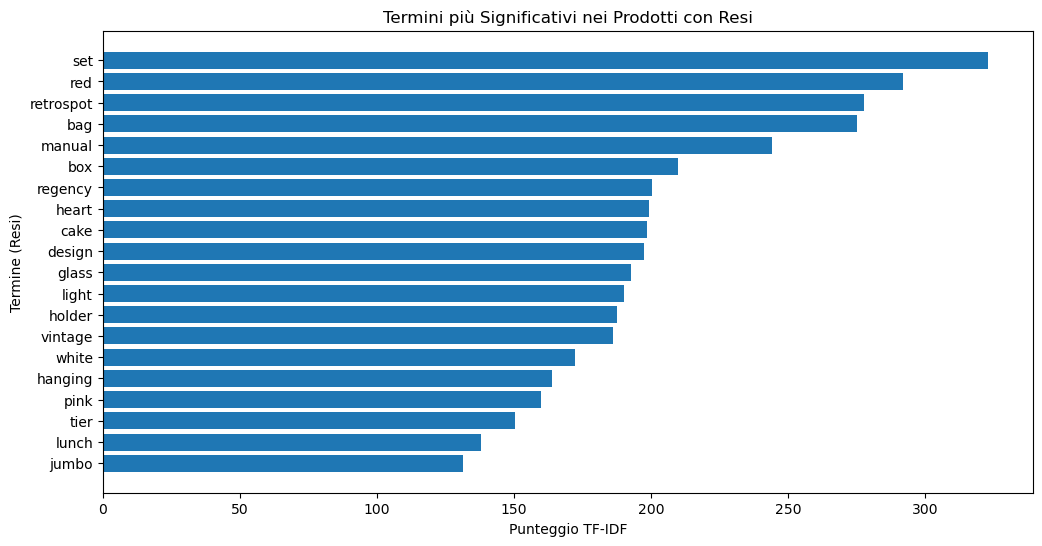

In [50]:
plt.figure(figsize=(12, 6))
plt.barh(tfidf_df_returns['term_resi'].head(20), tfidf_df_returns['tfidf_score_resi'].head(20))
plt.xlabel('Punteggio TF-IDF')
plt.ylabel('Termine (Resi)')
plt.title('Termini più Significativi nei Prodotti con Resi')
plt.gca().invert_yaxis()
plt.show()

### Interpretazione dei risultati
I termini mostrati nel bar plot con i punteggi TF-IDF più alti rappresetano le parole più rilevanti nelle descrizioni dei prodotti soggetti a resi. Notiamo quindi che i prodotti con termini come ad esempio `set`, `red`, `retrospot` sono quelli più soggetti a resi.

## Analisi Predittiva sui Resi
Dopo aver calcolato i termini TF-IDF più significativi per i resi, possiamo utilizzare questi termini per costruire un `Modello di Classificazione`. Integriamo i termini con le feature `Quantity` e `UnitPrice` per addestrare il modello.

### Definizione delle feature
Definiamo una lista di feature che contiene `Quantity`, `UnitPrice` e i `TF-IDF`. <br>
Tuttavia, precedentemente abbiamo calcolato solo i `TF-IDF` solo sui prodotti resi. Per usarli in un modello predittivo, dobbiamo trasformare tutte le descrizioni dei prodotti catturando la presenza/assenza di parole tipiche dei resi nei prodotti normali utilizzando lo stesso vectorizer dei resi.

In [54]:
tfidf_matrix_all = vectorizer_returns.transform(df['Description'])

features = ['Quantity', 'UnitPrice'] + vectorizer_returns.get_feature_names_out().tolist()
X_features = df[['Quantity','UnitPrice']].values

Convertiamo la matrice TF-IDf in array e la combiniamo con le altre feature

In [56]:
X_tfidf = tfidf_matrix_all.toarray()
X_combined = np.hstack((X_features, X_tfidf))

y=df['IsReturn']

### Train-Test Split e Calcolo dei Pesi
Stratifichiamo per garantire che ci sia una distribuzione simile delle classi nei set di addestramento e test. Tuttavia, poiché il `problema dell'imbalance` delle classi persiste calcoliamo anche i pesi. <br> Infatti il nostro dataset è molto sbilanciato in quanto la classe dei resi rappresenta solo il ~2% dell'intero dataset.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

### Addestramento del modello
Scegliamo di utilizzare il `Random Forest Classifier` per il modello di addestramento in quanto il dataset è particolarmente sbilanciato con `IsReturn` che rappresenta solo il 2% del dataset.<br>
Infatti, Random Forest costruisce molti `alberi decisionali` (foreste) durante l'addestramento e `randomizza` sia la selezione delle caratteristiche che la selezioni dei campioni di addestramento per ogni albero riducendo così il rischio di overfitting.

In [60]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuratezza:", accuracy_score(y_test, y_pred))
print("Rapporto di classificazione:\n", classification_report(y_test, y_pred))

Accuratezza: 1.0
Rapporto di classificazione:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104976
           1       1.00      1.00      1.00      1835

    accuracy                           1.00    106811
   macro avg       1.00      1.00      1.00    106811
weighted avg       1.00      1.00      1.00    106811



In [61]:
correlation_matrix = pd.DataFrame(X_combined, columns=features).corrwith(y)
print("Correlazione delle caratteristiche con la variabile target:")
print(correlation_matrix)

Correlazione delle caratteristiche con la variabile target:
Quantity     0.000410
UnitPrice   -0.000360
10          -0.000813
11           0.000092
12           0.002143
               ...   
word         0.001120
wrap         0.001505
wreath      -0.000697
yellow      -0.000701
zinc        -0.002242
Length: 502, dtype: float64


### Interpretazione dei Risultati del Modello di Classificazione
L'accuratezza del modello risulta essere sempre 1 (100%). Tuttavia, un'accuratezza così alta suggerisce che il modello potrebbe avere problemi come l'overfitting, ovvero il modello potrebbe aver memorizzato i dati di addestramento piuttosto che generalizzare su dati nuovi. <br>
Si nota infatti che la correlazione delle caratteristiche con la variabile target (`IsReturn`) è molto bassa per tutte le caratteristiche considerate. Questo significa che le correlazioni tra `Quantity` e `UnitPrice` con `isReturn` sono molto vicine a zero, indicando che non c'è una forte correlazione lineare tra queste caratteristiche e la variabile target `IsReturn` indicando che non sono molto informative per predire i resi.<br>
Pure i termini TF-IDF mostrano anch'essi correlazioni molto basse, suggerendo che individualmente, nessuno di questi termini è fortemente associato con i resi.

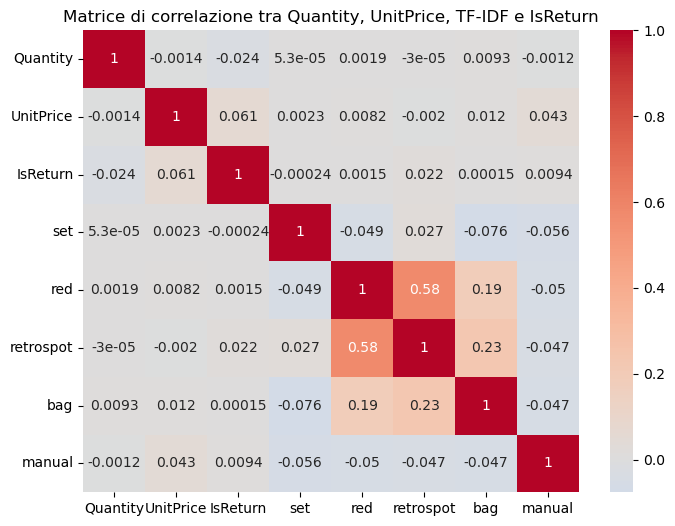

In [63]:
num_top_terms_returns = 10
top_tfidf_terms_returns = tfidf_df_returns['term_resi'].head(5).tolist()

tfidf_data_returns = pd.DataFrame(tfidf_matrix_returns.toarray(), columns=vectorizer_returns.get_feature_names_out())
tfidf_df_top_returns = tfidf_data_returns[top_tfidf_terms_returns]

correlation_data_returns = pd.concat([df[['Quantity', 'UnitPrice', 'IsReturn']], tfidf_df_top_returns], axis=1)

correlation_matrix_returns = correlation_data_returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_returns, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di correlazione tra Quantity, UnitPrice, TF-IDF e IsReturn')
plt.show()

### Conclusioni
+ Dalla matrice di correlazione si nota una bassa correlazione tra la maggior parte delle variabili, suggerendo che non ci sono forti relazioni lineari dirette con la variabile target. <br>
+ Alcuni termini mostrano correlazioni moderate tra di loro, suggerendo che ci sono alcuni pattern nelle descrizioni dei prodotti. Tuttavia, il termine `set`, che precedentemente abbiamo calcolato essere il termine più significativo nei prodotti resi con il metodo `TF-IDF`, risulta avere una correlazione molto bassa con `IsReturn` indicando che `i resi non sono fortemente influenzati dalla loro descrizione`.<br>
+ Infine sia `Quantity` che `UnitPrice` mostrano una bassa correlazione con `IsReturn`, indicando che i resi non sono fortemente influenzati dalla quantità acquistata o dal prezzo unitario.

Considerando la bassa correlazione delle caratteristiche con la variabile target ed essendo `Quantity`, `UnitPrice` e la `Descrizione` fattori non determinanti nei resi, concluderei quindi qui il mio tentativo di costruire un modello di apprendimento supervisionato, in quanto l'uso di modelli di apprendimento più complessi potrebbe non portare a significativi miglioramenti nelle performance predittive usando queste feature.

## Clustering dei Clienti
Precedentemente abbiamo fatto la segmentazione delle transazioni, individuando cluster di clienti. Possiamo ora segmentare ulteriormente i clienti che non hanno effettuato resi (appartenenti al `cluster 2`) usando il `Clustering RMF`, una tecnica di clustering che considera il `Recency`, `Frequency` e `Monetary value` tipica per la segmentazione delle transazione dei clienti per segmentarli in cluster. <br>
Di fianco l'analisi RMF è spesso usato il `clustering K-means` per segmentare ulteriormente i clienti in gruppi distinti.

### Recency

In [68]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df_no_returns = df[df['IsReturn'] == 0].copy()

snapshot_date = df_no_returns['InvoiceDate'].max() + pd.Timedelta(days=1)

recency = df_no_returns.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (snapshot_date - recency['InvoiceDate']).dt.days

### Frequency

In [70]:
frequency = df_no_returns.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.rename(columns={'InvoiceNo':'Frequency'}, inplace = True)

### Monetary

In [72]:
df_no_returns['TotalSpend'] = df_no_returns['Quantity'] * df_no_returns['UnitPrice']
monetary = df_no_returns.groupby('CustomerID')['TotalSpend'].sum().reset_index()
monetary.rename(columns={'TotalSpend': 'Monetary'}, inplace=True)

In [73]:
rfm = recency[['CustomerID', 'Recency']].merge(frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = rfm.merge(monetary[['CustomerID', 'Monetary']], on='CustomerID')

### Clustering con K-Means
#### Normalizzazione dei dati RFM per il clustering

In [75]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

#### Metodo del gomito
Utilizzo di nuovo il `Metodo del Gomito` per determinare il numero ottimale di cluster

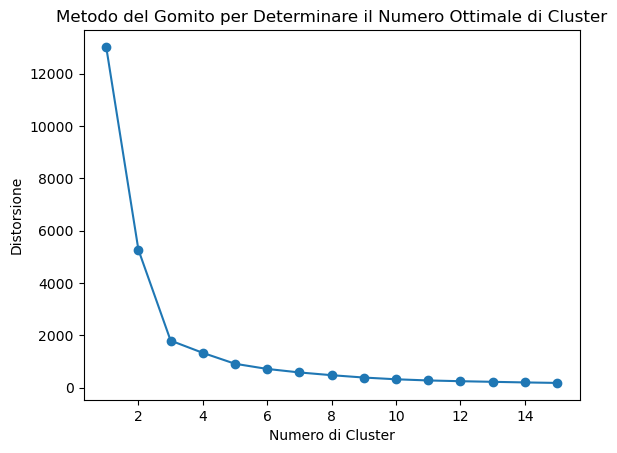


Il numero ottimale di cluster è: 13


In [77]:
dist = []

for i in range(1, 16):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    km.fit(rfm_scaled)
    dist.append(km.inertia_)

plt.plot(range(1, 16), dist, marker='o')
plt.xlabel('Numero di Cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del Gomito per Determinare il Numero Ottimale di Cluster')
plt.show()

optimal_k = 0
min_slope = float('inf')

for i in range(1, len(dist) - 1):
    slope = dist[i-1] - dist[i]
    next_slope = dist[i] - dist[i+1]
    if (slope - next_slope) < min_slope:
        min_slope = (slope - next_slope)
        optimal_k = i + 1

print(f"\nIl numero ottimale di cluster è: {optimal_k}")

In [78]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

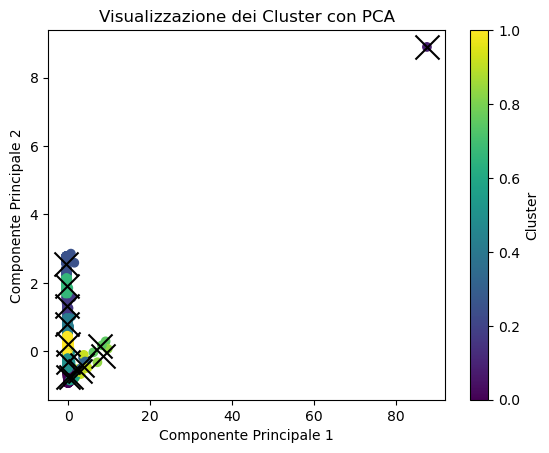

In [79]:
# Riduciamo la dimensione con PCA per visualizzare i cluster
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.scatter(principal_components[:, 0], principal_components[:,1], c=rfm['Cluster'], cmap='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='black', marker='x')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Visualizzazione dei Cluster con PCA')
plt.colorbar(label='Cluster')
plt.show()

In [80]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={
    'Recency': 'Recency Media',
    'Frequency': 'Frequency Media',
    'Monetary': 'Monetary Media'
})

print(cluster_summary)

         Recency Media  Frequency Media  Monetary Media
Cluster                                                
0            17.913381         4.203704    1.502535e+03
1             1.000000      1428.000000    1.754902e+06
2           228.572993         1.536496    6.868314e+02
3           351.149485         1.283505    7.494155e+02
4             7.666667        25.666667    1.055796e+05
5           172.424699         2.090361    7.412394e+02
6            62.092573         2.674919    1.080974e+03
7             9.891667        18.604167    8.766094e+03
8           284.731884         1.387681    4.392542e+02
9             3.666667        59.666667    2.447514e+05
10            1.000000       205.000000    8.838218e+04
11            6.500000        66.250000    4.118767e+04
12          113.857143         2.538265    9.170273e+02


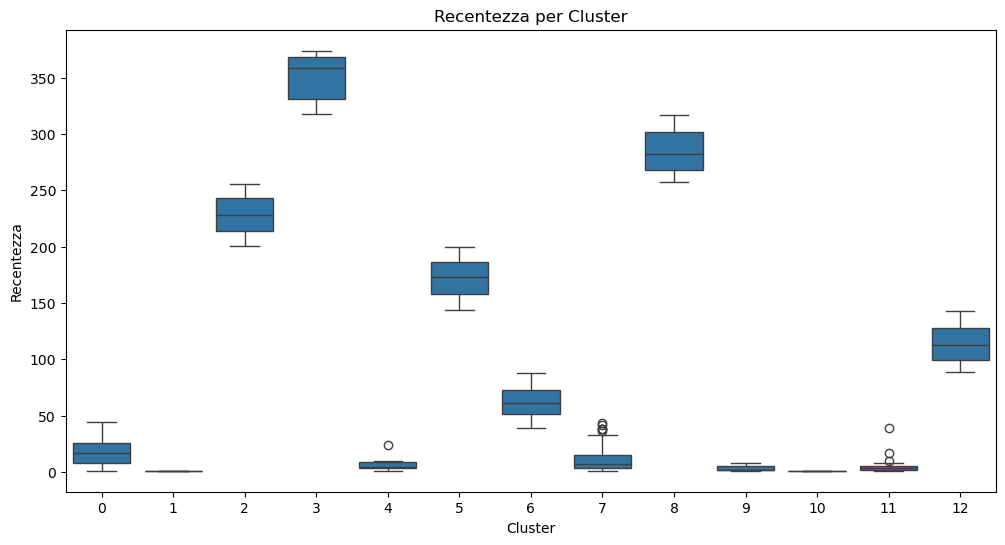

In [81]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recentezza per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recentezza')
plt.show()

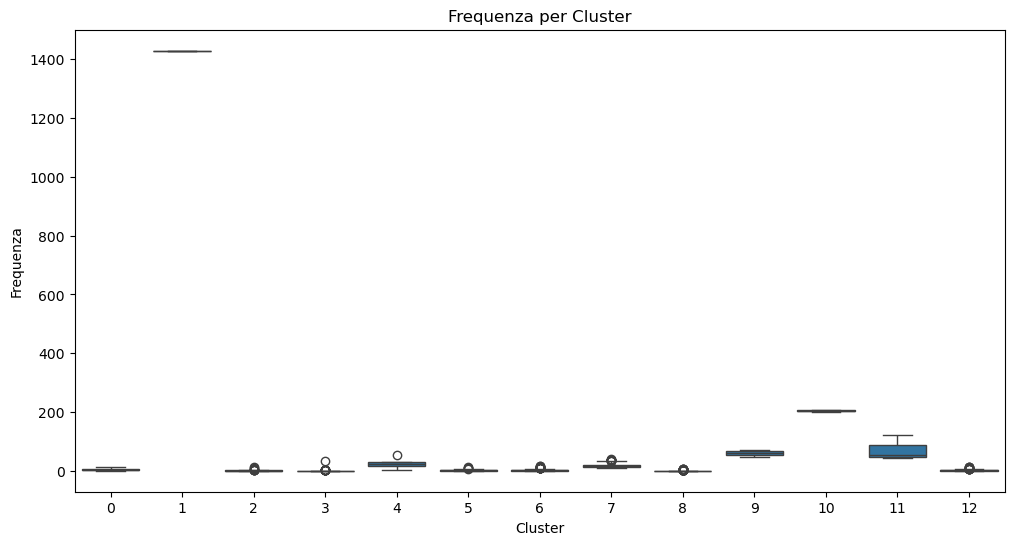

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequenza per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequenza')
plt.show()

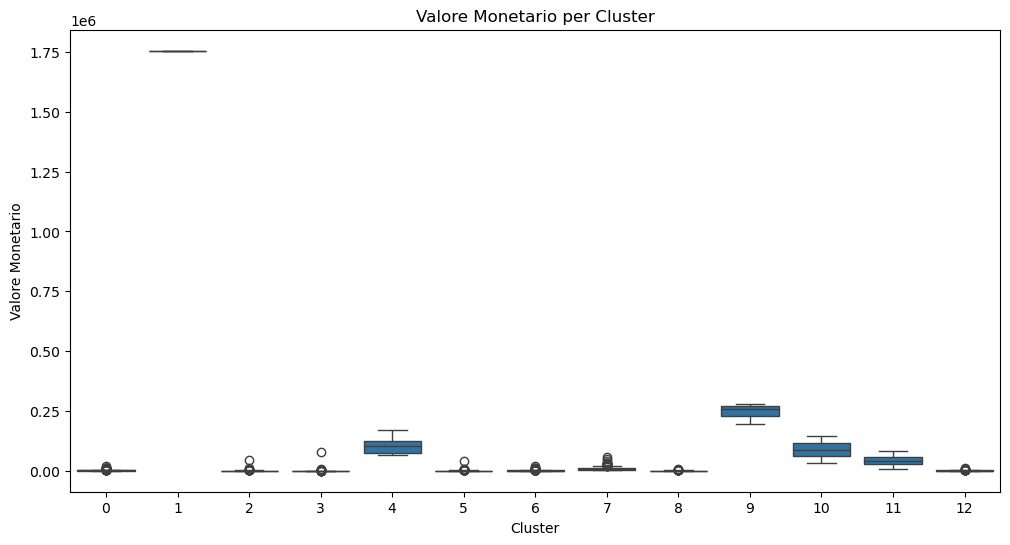

In [84]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Valore Monetario per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Valore Monetario')
plt.show()

### Risultati ottenuti
Con le tecniche di `Clustering RFM` e `K-Means` abbiamo identificato 13 cluster distinti di clienti (che non effettuano resi) basati su Recency, Frequency e Monetary Value. Inoltre, dalla visualizzazione dei boxplot, emerge che ci sono differenze significative tra i cluster, particolarmente evidenti per quanto riguarda la Recency.<br>
Confrontando i `boxplot` di `Frequency` e `Monetary`, non si notano differenze significative tra i cluster, mentre i boxplot di `Recency` mostrano una chiara variabilità. Questo indica che la `Recency` è un fattore determinante nel distinguere i vari cluster.<br>
La variazione dei valori di recency tra i cluster suggerisce che i clienti hanno comportamenti diversi in termini di quanto recentemente hanno effettuato acquisti. Alcuni cluster sono caratterizzati da clienti che hanno effettuato acquisti molto di recente, mentre altri includono clienti che non acquistano da molto tempo.

### Clustering con DBSCAN
#### Calcolo del eps

In [82]:
min_samples = 6
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

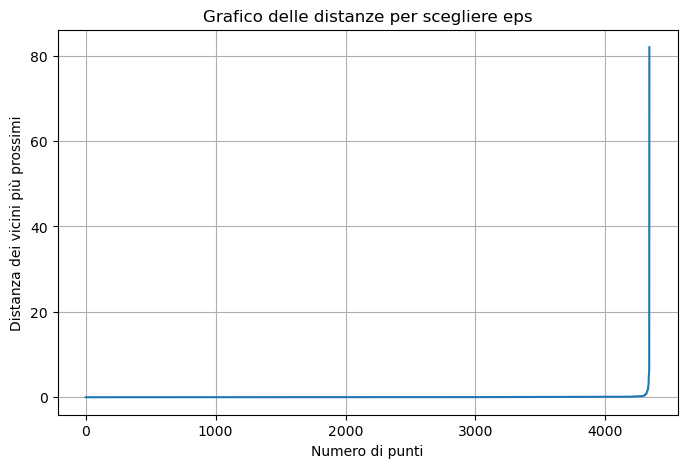

🔹 Valore ottimale di eps: 0.7625


In [87]:
distances = np.sort(distances[:, -1])

knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
eps_optimal = distances[knee_locator.knee]

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Numero di punti")
plt.ylabel("Distanza dei vicini più prossimi")
plt.title("Grafico delle distanze per scegliere eps")
plt.grid()
plt.show()

print(f"🔹 Valore ottimale di eps: {eps_optimal:.4f}")

In [88]:
dbscan = DBSCAN(eps=eps_optimal, min_samples = 6)
rfm['Cluster'] = dbscan.fit_predict(rfm_scaled)

print(rfm['Cluster'].value_counts())

Cluster
 0    4318
-1      21
Name: count, dtype: int64


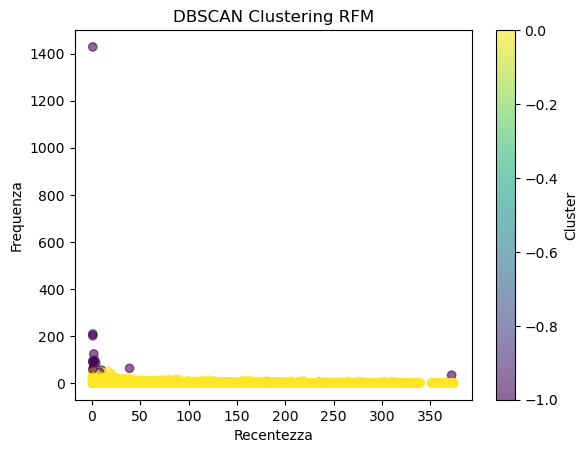

In [89]:
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Recentezza')
plt.ylabel('Frequenza')
plt.title('DBSCAN Clustering RFM')
plt.colorbar(label='Cluster')
plt.show()

Con DBSCAN si ottengono invece solo un cluster significativo `Cluster 0` e alcuni `outlier` in `Cluster -1`. 
+ **Cluster 0** (con 4318 clienti) identifica un cluster che contiene la maggior parte dei clienti, indicando che DBSCAN ha identificato un gruppo denso di clienti con comportamenti simili.
+ **Cluster -1** (con 21 clienti) indentifica clienti che sono considerati come `outliers`.

In [91]:
cluster_0 = rfm[rfm['Cluster'] == 0]
cluster_0.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster
count,4318.000000,4318.000000,4318.000000,4318.000000,4318.0
mean,15300.419407,92.682492,3.985873,1615.752708,0.0
std,1721.049826,99.920508,5.115713,3601.879396,0.0
min,12347.000000,1.000000,1.000000,3.750000,0.0
25%,13813.250000,18.000000,1.000000,305.652500,0.0
50%,15299.500000,51.000000,2.000000,663.905000,0.0
75%,16778.750000,142.750000,5.000000,1636.237500,0.0
max,18287.000000,374.000000,62.000000,65164.790000,0.0


In [92]:
cluster_1 = rfm[rfm['Cluster'] == -1]
cluster_1.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster
count,21.000000,21.000000,21.000000,2.100000e+01,21.0
mean,14569.476190,58.142857,130.904762,1.745376e+05,-1.0
std,3830.479051,114.965771,302.813788,3.702041e+05,0.0
min,0.000000,1.000000,1.000000,5.391210e+03,-1.0
25%,13089.000000,1.000000,28.000000,4.051984e+04,-1.0
50%,15098.000000,3.000000,60.000000,7.718360e+04,-1.0
75%,16684.000000,24.000000,93.000000,1.437112e+05,-1.0
max,18102.000000,372.000000,1428.000000,1.754902e+06,-1.0


### Analisi dei Cluster
+ **Cluster 0** ottenuto da DBSCAN rappersenta un gruppo eterogeneo di `clienti attivi` con una grande variabilità nel tempo trascorso dall'ultimo acquisto ` Recency` e nella frequenza degli acquisti `Frequency`. Inoltre, vi è una grande variabilità nelle spese `Monetary` indicando che questo cluster include sia clienti che spendono poco sia clienti che spondono molto.
+ **Cluster 1** ottenuto da DBSCAN rapprsentano quindi degli `outliers` rispetto ai comportamenti d'acquisto degli altri clienti (clienti che ad esempio spendono frequentemente e recentemente o clienti cha acquistavano frequentemente ma con un elevato tempo trascorso dall'ultimo acquisto).

### Differenze tra DBSCAN e K-Means
+ La principale ed evidente differenza tra i due algoritmi consiste nel `numero di cluster` trovati. K-Means infatti divide i dati in un numero predefinito di cluster (in questo caso 13), `minimizzando la varianza` all'interno dei cluster. DBSCAN invece identifica cluster basati sulla densità, senza bisogno di specificare il numero di cluster in anticipo, e segnala i punti che non appartengono a nessun cluster come outliers.
+ Questo perché K-Means non ha un meccanismo intrinseco per identificare outliers, mentre DBSCAN identifica automaticamente i punti che non appartengono a nessun cluster come `outliers`.

### Conclusioni
Utilizzando due algoritmi di clustering diversi sulle stesse feature (`Recency`, `Frequency` e `Monetary`) si ottengono due diverse segmentazioni dei clienti. DBSCAN ha identificato due gruppi principali: un cluster di clienti con un  e un gruppo di outliers. K-Means invece ha suddiviso i clienti in 13 cluster distinti, ciascuno con comportamenti di acquisto unici.